# Introduction

This Jupyter Notebook uses the NCAR Community Earth System Model Large Ensemble (CESM-LE). The notebook uses an example the Kay et al. (2015) paper describing the CESM LENS dataset ([doi:10.1175/BAMS-D-13-00255.1](https://doi.org/10.1175/BAMS-D-13-00255.1))

The objective of the notebook is to make an illustrative figure for a lead out in my masters thesis of projected trends in krill production over the next 20/50 years. The figure will make a map of trend magnitude.
Conceptually, this process begins by computing a 20 year trend and a 50 year trend at every grid point. Then computing the standard deviation of those trends across the ensemble. Then computing PDFs of regional trends (trends within particular regions of interest) and plotting the PDF of these trends.


Notebook version 3.3 (2020 April 17)
____

I would like to compute and make a figure of the trends in krill production over the next 20 and/or 50 years. Then I would like to make a map of trend magnitude in which:
- at every grid point I compute a 20 and 50 year trend (the DJF trend)
- then compute the standard deviation of those trends across the ensemble
- then I want to compute PDFs of regional trends - specifically looking at the antarctic peninsula region
- then lastly plot the PDF of regional trends

## Set up environment

In [1]:
# set up modules
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.colors as colors
from matplotlib import style


import intake
import pop_tools

import util

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


In [2]:
pwd = os.getcwd()
pwd

'/glade/u/home/zephyrs/projects/krill-cesm-le/notebooks'

In [3]:
ds = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries.zarr')
ds2 = xr.open_zarr('data/cesm-le-fields-djf-regional-timeseries-chl-edit.zarr')

## Compute Linear Trend
Define helper functions for trend computation.

In [4]:
def linear_trend(da, dim='time'):
    da_chunk = da.chunk({dim: -1})
    trend = xr.apply_ufunc(calc_slope,
                           da_chunk,
                           vectorize=True,
                           input_core_dims=[[dim]],
                           output_core_dims=[[]],
                           output_dtypes=[np.float],
                           dask='parallelized')
    return trend


def calc_slope(y):
    """ufunc to be used by linear_trend"""
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0]

Compute linear trends on the full ensemble.

In [14]:
kgp_parms = np.polyfit(ds2.time, ds2.KGP.stack(ens_space=['member_id','length','region']), 1)
kgp_parms.shape

(2, 306)

In [15]:
slope = kgp_parms[0,:]
intercept = kgp_parms[1,:]

In [27]:
trend = linear_trend(ds.KGP)

trend_present = linear_trend(ds.KGP.sel(time=slice(1920, 2005)))
trend_past = linear_trend(ds.KGP.sel(time=slice(2020, 2070)))


(array([2., 1., 1., 6., 4., 5., 5., 5., 3., 2.]),
 array([-8.63436362e-06, -7.88381907e-06, -7.13327452e-06, -6.38272996e-06,
        -5.63218541e-06, -4.88164086e-06, -4.13109631e-06, -3.38055176e-06,
        -2.63000721e-06, -1.87946265e-06, -1.12891810e-06]),
 <a list of 10 Patch objects>)

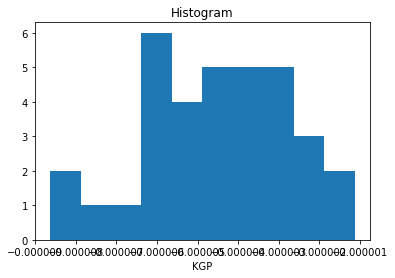

In [20]:
trend.isel(region=1, length=1).plot.hist()

(array([3., 3., 3., 5., 3., 6., 6., 3., 1., 1.]),
 array([-1.91900512e-05, -1.69862305e-05, -1.47824099e-05, -1.25785892e-05,
        -1.03747685e-05, -8.17094782e-06, -5.96712714e-06, -3.76330646e-06,
        -1.55948578e-06,  6.44334896e-07,  2.84815558e-06]),
 <a list of 10 Patch objects>)

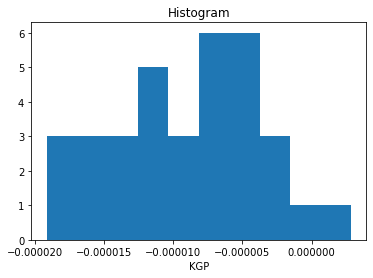

In [21]:
trend_present.isel(region=1, length=1).plot.hist()

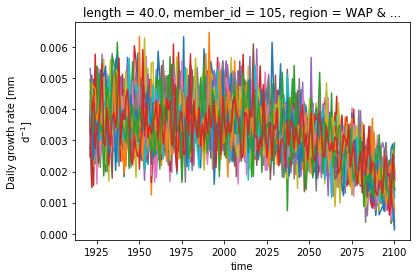

In [22]:
for member_id in ds2.member_id:
    ds2.KGP.sel(member_id=member_id).isel(length=1, region=1).plot()

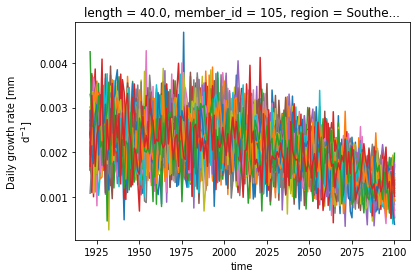

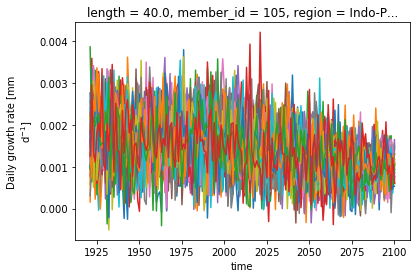

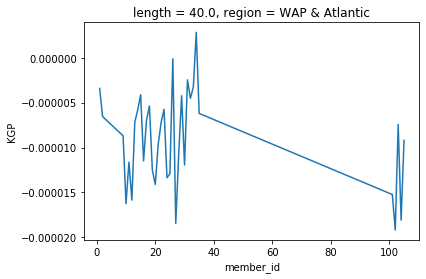